# Getting started
Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [1]:
!pwd


/Users/smoot/Desktop/ga/DSI_SM_01/projects/01-projects-weekly/project-03/starter-code


In [161]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model
%matplotlib inline
df = pd.read_csv('/Users/smoot/Desktop/ga/DSI_SM_01/Iowa_Liquor_sales_sample_10pct.csv', dtype = {'Zip Code': 'str', 
                                                                                                 'Category' : 'str'})
#they put all the columns with $ in a new variable and then ran a lambda function to drop it
# df['Vendor Number'].astype(str)

In [163]:
df.head(1)

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38


In [164]:
df['Date'] = pd.to_datetime(df['Date'])


In [165]:
df.columns = df.columns.str.replace(r'\(', '')
df.columns = df.columns.str.replace(')', '')
df = df.drop(['County'],  axis = 1)
df = df.drop(['Category Name'], axis = 1)
df = df.drop(['Item Number'], axis = 1)


In [167]:
df['State Bottle Cost'] = df['State Bottle Cost'].astype(str)
df['State Bottle Retail'] = df['State Bottle Retail'].astype(str)
df['Sale Dollars'] = df['Sale Dollars'].astype(str)
df['State Bottle Cost'] = df['State Bottle Cost'].str.replace('$', '')
df['State Bottle Retail'] = df['State Bottle Retail'].str.replace('$', '')
df['Sale Dollars'] = df['Sale Dollars'].str.replace('$', '')
df.head(1)

,Date,Store Number,City,Zip Code,County Number,Category,Vendor Number,Item Description,Bottle Volume ml,State Bottle Cost,State Bottle Retail,Bottles Sold,Sale Dollars,Volume Sold Liters,Volume Sold Gallons
0,2015-11-04,3717,SUMNER,50674,9.0,1051100.0,55,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2.38


In [176]:
df['State Bottle Cost'] = df['State Bottle Cost'].astype(float)
df['State Bottle Retail'] = df['State Bottle Retail'].astype(float)
df['Sale Dollars'] = df['Sale Dollars'].astype(float)
df['Store Number'] = df['Store Number'].astype(str)
df['Bottle Volume ml'] = df['Bottle Volume ml'].astype(float)
df['Bottles Sold'] = df['Bottles Sold'].astype(float)
df['County Number'] = df['County Number'].astype(str)
# df.isnull().sum()



In [169]:
# df = df.dropna()
df.shape

(270955, 15)

In [102]:
# df.dtypes


(269258, 15)

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt


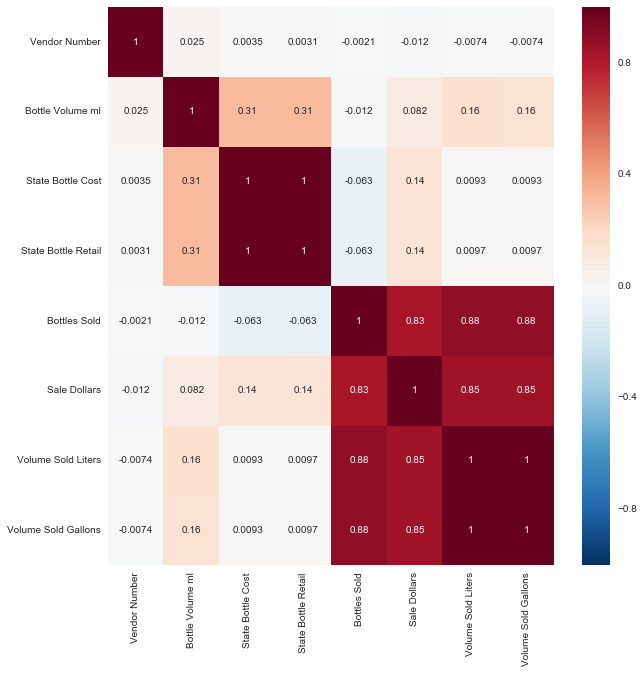

In [35]:
np.std(df)
np.var(df)
corr = df.corr()
plt.figure(figsize = (10, 10))
sns.heatmap(corr, annot = True)

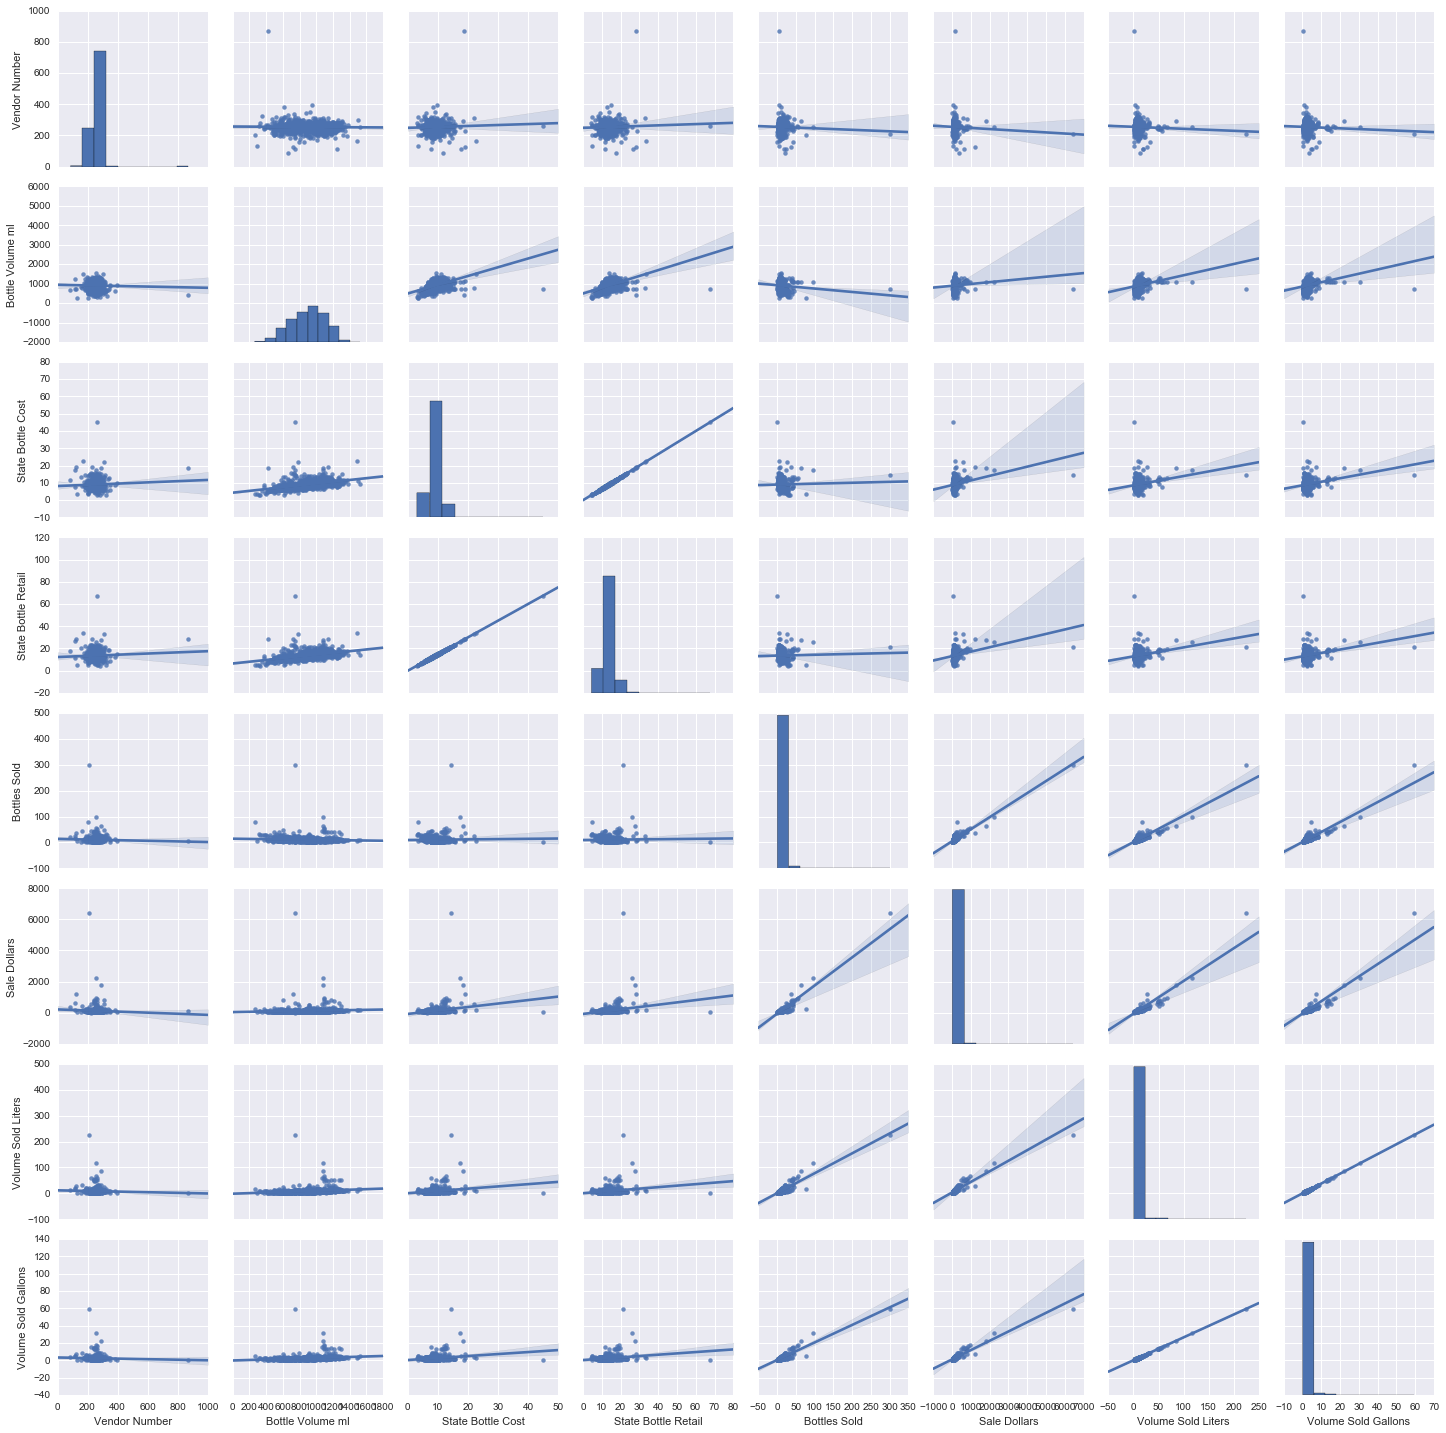

In [147]:
store_number = df.groupby(['Store Number']).mean()
sns.pairplot(store_number, kind = 'reg', palette = 'Set2')

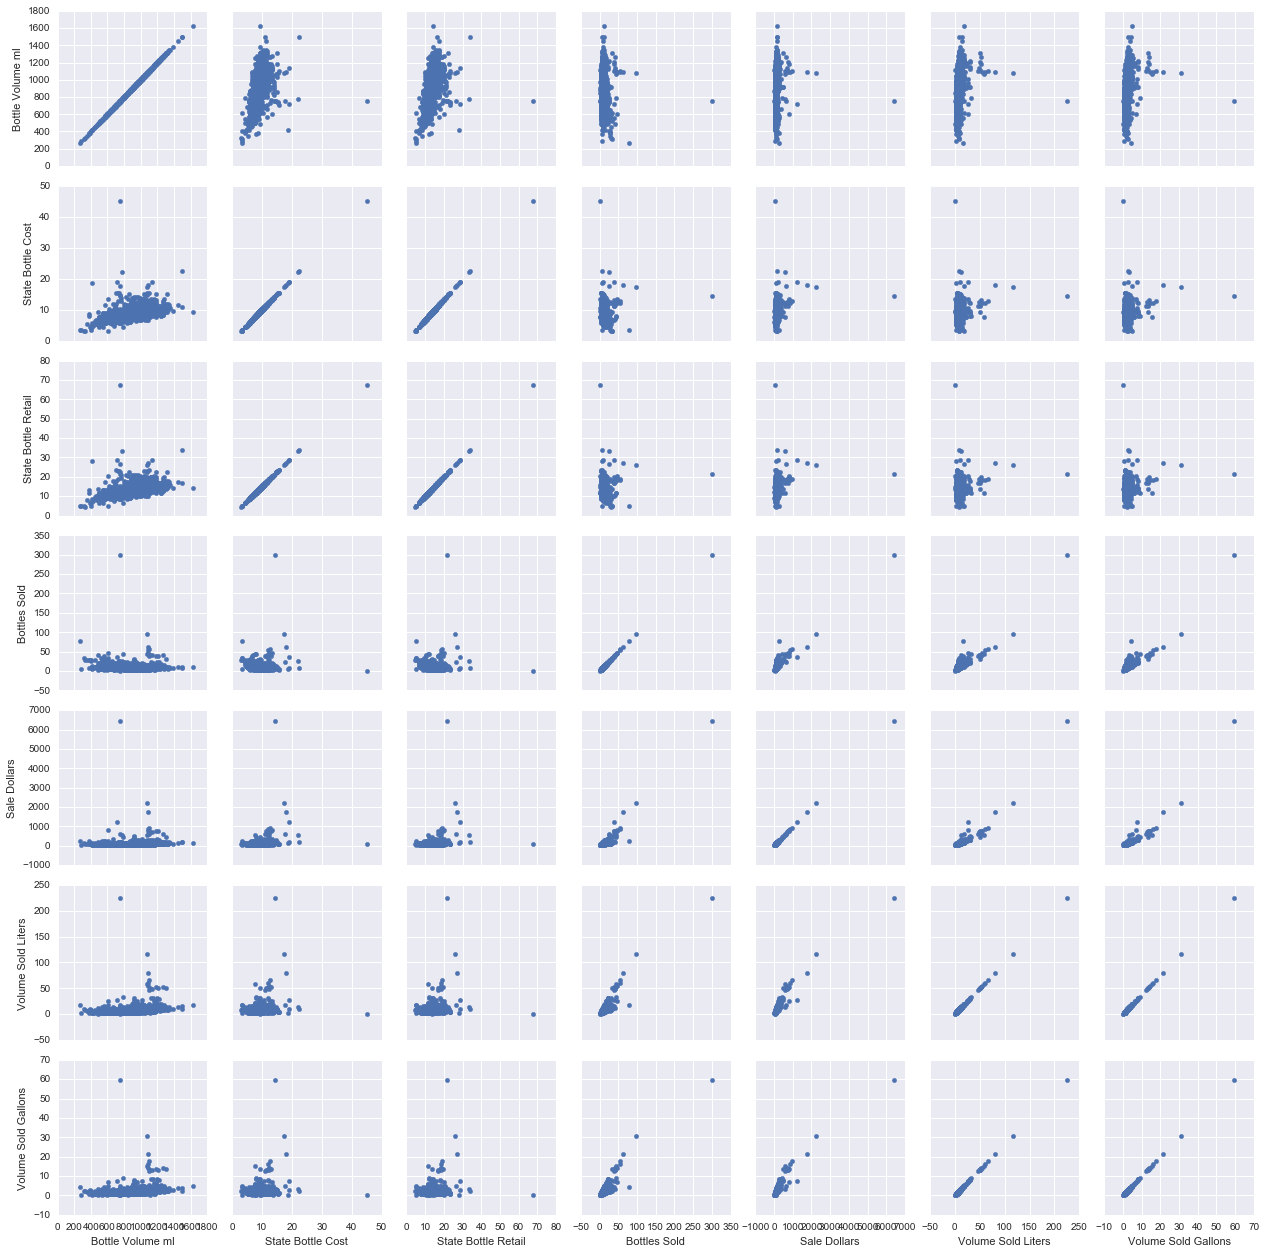

In [113]:
g = sns.PairGrid(store_number, dropna = True)
g.map(plt.scatter)

## Record your findings

Be sure to write out any observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

In [171]:
#2015 sales only
start_date = pd.Timestamp('20150101')
end_date = pd.Timestamp('20151231')
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)

# Filter the Data (this is from lab 3.3 and 3.4)
Some stores may have opened or closed in 2015. These data points will heavily skew our models, so we need to filter them out or find a way to deal with them.
You'll need to provide a summary in your project report about these data points. You may also consider using the monthly sales in your model and including other information (number of months or days each store is open) in your data to handle these unusual cases.
Let's record the first and last sales dates for each store. We'll save this information for later when we fit our models.

In [172]:
# Stores open all of 2015
dates = df.groupby(by=["Store Number"], as_index=False)
dates = dates.agg({"Date": [np.min, np.max]})
dates.columns = [' '.join(col).strip() for col in dates.columns.values]
dates.head()
# Filter out stores that opened or closed in 2015
first_year = pd.Timestamp("20150301")
end_year = pd.Timestamp("20151001")
mask = (dates['Date amin'] < first_year) & (dates['Date amax'] > end_year)
good_stores = dates[mask]["Store Number"]
df = df[df["Store Number"].isin(good_stores)]
df.shape

(257434, 15)

In [149]:
# open_all.sort(['Date'])
# open_all['Store Number'].unique
df.head(1)

,Date,Store Number,City,Zip Code,County,Category,Vendor Number,Item Description,Bottle Volume ml,State Bottle Cost,State Bottle Retail,Bottles Sold,Sale Dollars,Volume Sold Liters,Volume Sold Gallons
22111,2015-01-08,2106,CEDAR FALLS,50613,Black Hawk,1062200.0,35,Bacardi Superior Rum,1000.0,9.5,14.25,36.0,513.0,36.0,9.51


# Compute New Columns and Tables from lab!!!
Since we're trying to predict sales and/or profits, we'll want to compute some intermediate data. There are a lot of ways to do thisand good use of pandas is crucial. For example, for each transaction we may want to know:

margin, retail cost minus bottle cost

price per bottle

price per liter

We'll need to make a new dataframe that indexes quantities by store:

sales per store for all of 2015

sales per store for Q1 2015

sales per store for Q1 2016

total volumes sold

mean transaction revenue, gross margin, price per bottle, price per liter, etc.

average sales per day

number of days open

Make sure to retain other variables that we'll want to use to build our models, such as zip code, county number, city, etc. We recommend that you spend some time thinking about the model you may want to fit and computing enough of the suggested quantities to give you a few options.

Bonus tasks:
Restrict your attention to stores that were open for all of 2015 and Q1 2016. Stores that opened or closed in 2015 will introduce outliers into your data.
For each transaction we have the item category. You may be able to determine the store type (primarily wine, liquor, all types of alcohol, etc.) by the most common transaction category for each store. This could be a useful categorical variable for modelling.

In [173]:
# profit margin
df['Profit Margin'] = (df['State Bottle Retail'] - df['State Bottle Cost']) * df['Bottles Sold']


In [174]:
#Price per liter
df['Price Per Liter'] = df['Sale Dollars'] / df['Volume Sold Liters'] 
df.head(1)

,Date,Store Number,City,Zip Code,County Number,Category,Vendor Number,Item Description,Bottle Volume ml,State Bottle Cost,State Bottle Retail,Bottles Sold,Sale Dollars,Volume Sold Liters,Volume Sold Gallons,Profit Margin,Price Per Liter
0,2015-11-04,3717,SUMNER,50674,9.0,1051100.0,55,Mr. Boston Apricot Brandy,750.0,4.5,6.75,12.0,81.0,9.0,2.38,27.0,9.0


In [189]:
df.sort_values(by=["Store Number", "Date"], inplace=True)
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20151231")
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
sales = df[mask]

# Group by store name
sales = sales.groupby(by=["Store Number"], as_index=False)

# Compute sums, means
sales = sales.agg({"Sale Dollars": [np.sum, np.mean],
                   "Volume Sold Liters": [np.sum, np.mean],
                   "Profit Margin": np.mean,
                   "Price Per Liter": np.mean,
                   "Zip Code": lambda x: x.iloc[0], 
                   "City": lambda x: x.iloc[0],
                   "County Number": lambda x: x.iloc[0]})

# Collapse the column indices
sales.columns = [' '.join(col).strip() for col in sales.columns.values]

# Rename columns
sales.columns = [u'Store Number', u'City', u'2015 Sales',
       u'2015 Sales mean', u'County Number',
       u'Price Per Liter mean', u'2015 Volume Sold Liters mean',
       u'2015 Volume Sold Liters', u'Zip Code',
       u'2015 Profit Margin mean']
sales.head()

,Store Number,City,2015 Sales,2015 Sales mean,County Number,Price Per Liter mean,2015 Volume Sold Liters mean,2015 Volume Sold Liters,Zip Code,2015 Profit Margin mean
0,2106,CEDAR FALLS,9731.85,18.466509,146326.22,277.658861,7.0,17.856601,50613,92.671879
1,2113,GOWRIE,659.85,4.488776,9310.22,63.334830,94.0,18.507700,50543,21.149932
2,2130,WATERLOO,6891.37,17.580026,111871.43,285.386301,7.0,16.835809,50703,95.217347
3,2152,ROCKWELL,633.37,4.491986,7721.08,54.759433,17.0,13.020765,50469,18.351277
4,2178,WAUKON,1917.12,8.089114,24324.18,102.633671,3.0,16.053844,52172,34.454430


In [190]:
# Q1 Sales 2015
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20150331")
df.sort_values(by=["Store Number", "Date"], inplace=True)
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df2 = df[mask].groupby(by=["Store Number"], as_index=False)["Sale Dollars"].sum()
sales["2015 Sales Q1"] = df2["Sale Dollars"]
sales.head()

,Store Number,City,2015 Sales,2015 Sales mean,County Number,Price Per Liter mean,2015 Volume Sold Liters mean,2015 Volume Sold Liters,Zip Code,2015 Profit Margin mean,2015 Sales Q1
0,2106,CEDAR FALLS,9731.85,18.466509,146326.22,277.658861,7.0,17.856601,50613,92.671879,39287.29
1,2113,GOWRIE,659.85,4.488776,9310.22,63.334830,94.0,18.507700,50543,21.149932,2833.25
2,2130,WATERLOO,6891.37,17.580026,111871.43,285.386301,7.0,16.835809,50703,95.217347,24272.57
3,2152,ROCKWELL,633.37,4.491986,7721.08,54.759433,17.0,13.020765,50469,18.351277,2003.46
4,2178,WAUKON,1917.12,8.089114,24324.18,102.633671,3.0,16.053844,52172,34.454430,5856.41


In [187]:
# Sales 2016 Q1
start_date = pd.Timestamp("20160101")
end_date = pd.Timestamp("20160331")
df.sort_values(by=["Store Number", "Date"], inplace=True)
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df2 = df[mask].groupby(by=["Store Number"], as_index=False)["Sale Dollars"].sum()
sales["2016 Sales Q1"] = df2["Sale Dollars"]


In [ ]:
# Q1 sales, may want to also use aggregate as above to have more columns (means, etc.)

# Sales 2015  Q1

# Sales 2016 Q1

In [191]:
# Save this dataframe

# Let's add the dates computed above to this data.
sales["First Date"] = dates['Date amin']
sales["Last Date"] = dates['Date amax']

sales.head()

,Store Number,City,2015 Sales,2015 Sales mean,County Number,Price Per Liter mean,2015 Volume Sold Liters mean,2015 Volume Sold Liters,Zip Code,2015 Profit Margin mean,2015 Sales Q1,First Date,Last Date
0,2106,CEDAR FALLS,9731.85,18.466509,146326.22,277.658861,7.0,17.856601,50613,92.671879,39287.29,2015-01-08,2016-03-31
1,2113,GOWRIE,659.85,4.488776,9310.22,63.334830,94.0,18.507700,50543,21.149932,2833.25,2015-01-07,2016-03-23
2,2130,WATERLOO,6891.37,17.580026,111871.43,285.386301,7.0,16.835809,50703,95.217347,24272.57,2015-01-08,2016-03-31
3,2152,ROCKWELL,633.37,4.491986,7721.08,54.759433,17.0,13.020765,50469,18.351277,2003.46,2015-01-08,2016-03-17
4,2178,WAUKON,1917.12,8.089114,24324.18,102.633671,3.0,16.053844,52172,34.454430,5856.41,2015-01-07,2016-03-30


In [192]:
sales.to_csv("sales_iowa.csv")

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [1]:
from sklearn import linear_model


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.